In [116]:
#import custom modules
from importlib import reload
from helpers.my_imports import *
import helpers.preprocessing as pp
import helpers.plot as plot
import helpers.tools as tools
import helpers.transformers as xfrs
from helpers.reload import myreload

#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from sklearn.preprocessing import LabelEncoder
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

#make sure latest copy of library is loaded
myreload()

#Global Variable for Random State
rs=42 #random_state

#Reload dataframe
df = pd.read_csv('saved_dfs/preprocessed_negotiations_df.csv')

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.


In [117]:
def get_clf_model(hidden_layer_sizes, meta, dropout_rate=0.2):
    model = Sequential()
    inp = Input(shape=(meta["n_features_in_"]))
    model.add(inp)
    for hidden_layer_size in hidden_layer_sizes:
        layer = Dense(hidden_layer_size, activation="relu")
        model.add(layer)
        model.add(Dropout(dropout_rate))
    if meta["target_type_"] == "binary":
        n_output_units = 1
        output_activation = "sigmoid"
        loss = "binary_crossentropy"
    elif meta["target_type_"] == "multiclass":
        n_output_units = meta["n_classes_"]
        output_activation = "softmax"
        loss = "sparse_categorical_crossentropy"
    else:
        raise NotImplementedError(f"Unsupported task type: {meta['target_type_']}")
    out = Dense(n_output_units, activation=output_activation)
    model.add(out)
    model.compile(loss=loss)
    #model.summary()
    return model

In [118]:
models= {
    'k_clf': KerasClassifier(
    model=get_clf_model,
    hidden_layer_sizes=(10, 5),
    optimizer="adam",
    optimizer__learning_rate=0.01, #0.001
    epochs=50,
    batch_size=32,
    verbose=0,) }

## Define X, y
Redefine X and y based on what we learned in Feature Engineering

In [119]:
#Define X and y
X,y=df.drop(columns=['decision', 'billed_amount', 'negotiation_amount', 'offer', 'counter_offer']), df.decision

encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

#Split and stratify the data
X_train, X_test, y_train, y_test = train_test_split(X,encoded_y, stratify=None, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6398, 20), (2133, 20), (6398,), (2133,))

In [120]:
ohe_cols = ['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type', 'in_response_to', 
            'facility', 'plan_funding']
cat_cols = ['carrier', 'TPA', 'group_number','TPA_rep']
ord_cols = ['level']
num_cols = ['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer',
            'service_days', 'offer_days', 'counter_offer_days', 'decision_days', 'YOB']


transformer = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('yeo', PowerTransformer(method='yeo-johnson')), 
        ]), num_cols),
        ('cat', Pipeline([
            ('combiner', xfrs.RareCategoryCombiner()),
            ('cat_encoder', BinaryEncoder())
        ]), cat_cols),
        ('ohe', OneHotEncoder(), ohe_cols),
        ('ord', OrdinalEncoder(), ord_cols)
    ],
    remainder='passthrough'
)
transformer.fit(X_train, y_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('yeo', PowerTransformer())]),
                                 ['neg_to_billed', 'offer_to_neg',
                                  'offer_to_counter_offer', 'service_days',
                                  'offer_days', 'counter_offer_days',
                                  'decision_days', 'YOB']),
                                ('cat',
                                 Pipeline(steps=[('combiner',
                                                  RareCategoryCombiner()),
                                                 ('cat_encoder',
                                                  BinaryEncoder())]),
                                 ['carrier', 'TPA', 'group_number', 'TPA_rep']),
                                ('ohe', OneHotEncoder(),
                                 ['claim_type', 'NSA_NNSA', 'split_claim',
                                  'negotiation_type', 'in_response_to',
                                  'facility', 'plan_funding']),
                                ('ord', OrdinalEncoder(), ['level'])])

In [121]:
models= {
    'k_clf': KerasClassifier(
    model=get_clf_model,
    hidden_layer_sizes=(10, 5),
    optimizer="adam",
    optimizer__learning_rate=0.001,
    epochs=50,
    verbose=0,) }

In [122]:
pipeline = Pipeline(steps=[
    ('transformer', transformer),
    #('feature_selector', SelectKBest(score_func=f_classif, k=10)),  # Adjust 'k' as needed
    ('k_clf', models['k_clf'])
]).fit(X_train, y_train)


In [123]:
f1_score(y_test, pipeline.predict(X_test), pos_label=1)

0.9639429312581064

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.


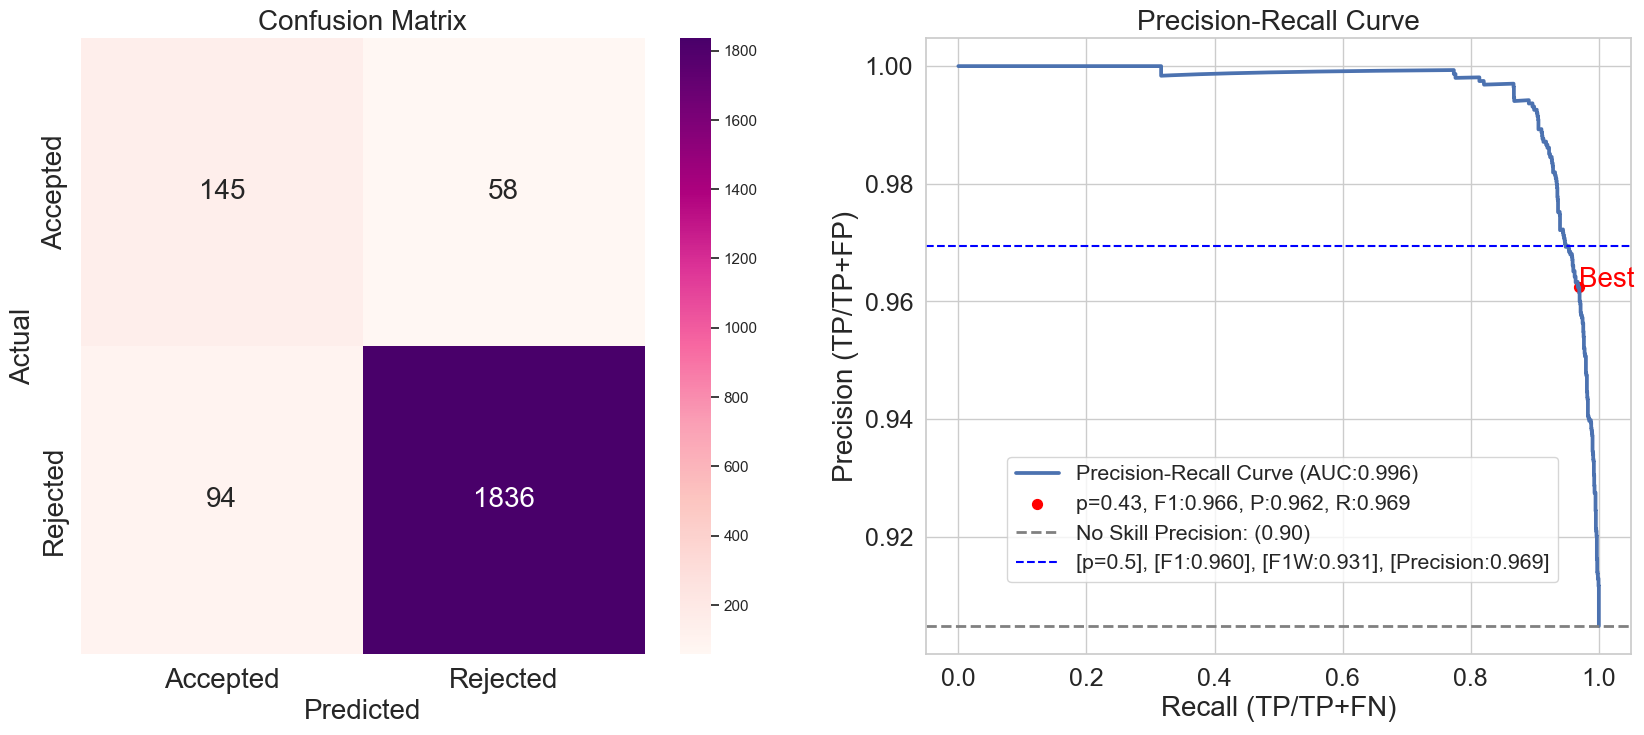

In [77]:
myreload()
plot.conf_matrix_PRC(pipeline, X_test, y_test, probas_pos_index=1, class_labels=['Accepted', 'Rejected'], threshold=0.5, common_fontsize=20, figx=20, figy=8, xlegend=0.1, ylegend=0.1)

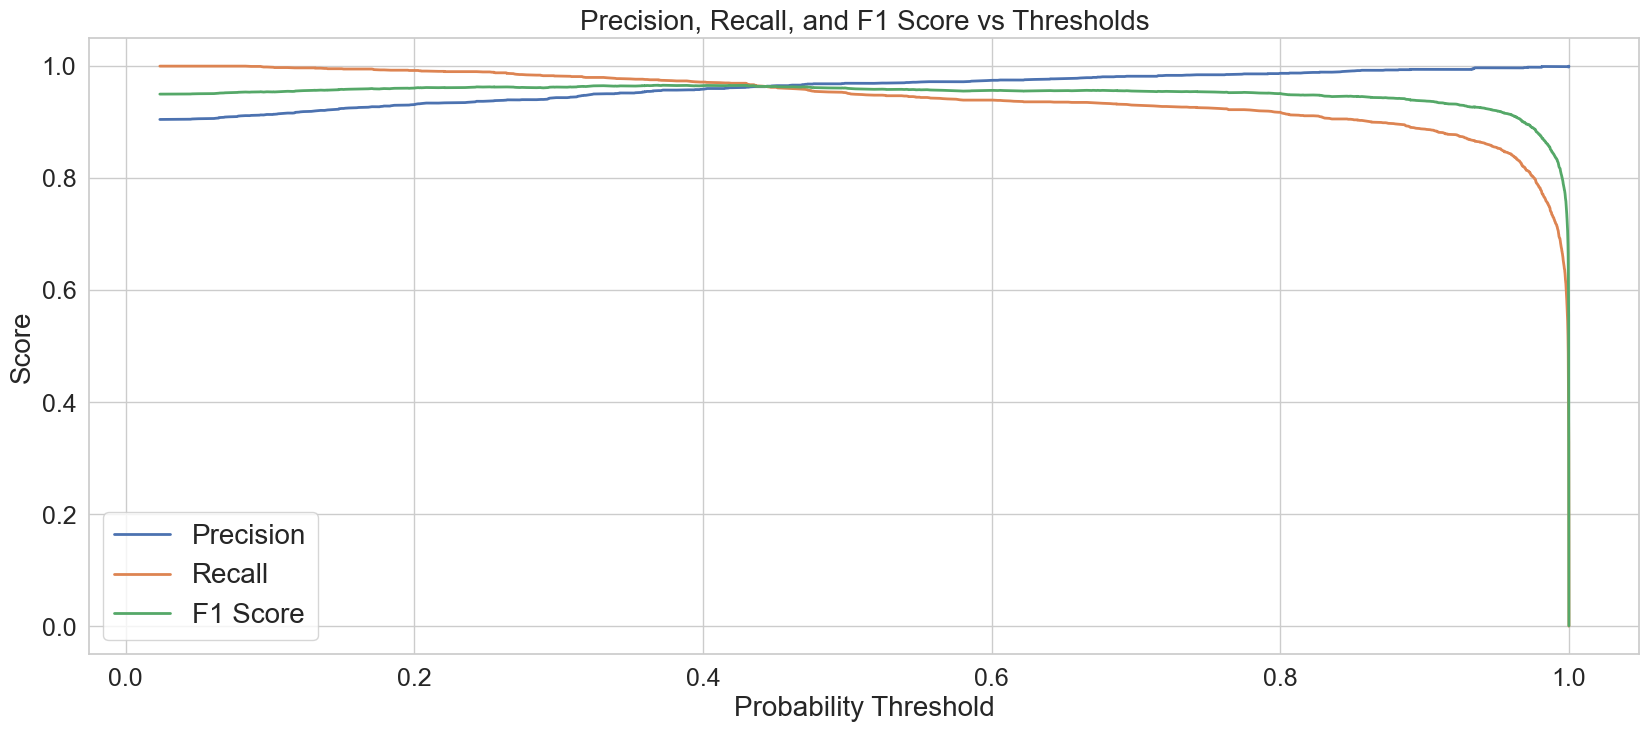

In [76]:
plot.scores_vs_thresholds(pipeline, X_test, y_test, probas_pos_index=1, common_fontsize=20, figx=20, figy=8)

### CV

In [112]:
"""tools.my_cross_val(df_le, 'decision', scoring_metrics, models, 
                   num_imputer=('si',SimpleImputer(strategy='most_frequent')),  
                   num_cols=[ 'offer_to_neg', 
                             'counter_offer_days', 'offer_days', 'decision_days', 'service_days', 'YOB'],
                   
                   cat_encoder=('cat_encoder', BinaryEncoder()),
                   cat_cols=[], ['carrier', 'TPA', 'TPA_rep', 'group_number'], 
                   
                   onehotencoder=('ohe', OneHotEncoder(drop='if_binary')),
                   ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type', 'in_response_to', 'facility', 'plan_funding'],
                   ord_cols=[], ['level'], 

                   scaler= ('scaler', RobustScaler()),
                     
                   set_name='test', cv=5, verbose=0,
                   test_size=0.25, stratify=False,rs=42)"""

"tools.my_cross_val(df_le, 'decision', scoring_metrics, models, \n                   num_imputer=('si',SimpleImputer(strategy='most_frequent')),  \n                   num_cols=[ 'offer_to_neg', \n                             'counter_offer_days', 'offer_days', 'decision_days', 'service_days', 'YOB'],\n                   \n                   cat_encoder=('cat_encoder', BinaryEncoder()),\n                   cat_cols=[], ['carrier', 'TPA', 'TPA_rep', 'group_number'], \n                   \n                   onehotencoder=('ohe', OneHotEncoder(drop='if_binary')),\n                   ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type', 'in_response_to', 'facility', 'plan_funding'],\n                   ord_cols=[], ['level'], \n\n                   scaler= ('scaler', RobustScaler()),\n                     \n                   set_name='test', cv=5, verbose=0,\n                   test_size=0.25, stratify=False,rs=42)"

In [81]:
params= {
    'k_clf__optimizer__learning_rate': [0.001, 0.1],
    'k_clf__dropout_rate': [0, 0.2, 0.3]
}
search=RandomizedSearchCV(pipeline, param_distributions=params, cv=3, n_iter=2, random_state=rs)
search.fit(X_train, y_train)
pd.DataFrame(search.cv_results_)

ValueError: Invalid parameter dropout_rate for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(dropout_rate=0)`
Check the list of available parameters with `estimator.get_params().keys()`

In [56]:
param_distributions= {
    'k_clf__optimizer__learning_rate': [0.001, 0.1]
    'k_clf__dropout_rate': [0, 0.2, 0.3]
}
search=RandomizedSearchCV(pipeline, param_distributions={}, cv=3, random_state=rs)
search.fit(X_train, y_train)
search.cv_results_

/Users/basilhaddad/anaconda3/envs/snowflakes/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning:

The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.



{'mean_fit_time': array([30.13039009]),
 'std_fit_time': array([1.04731103]),
 'mean_score_time': array([0.23878296]),
 'std_score_time': array([0.00614113]),
 'params': [{}],
 'split0_test_score': array([0.94796062]),
 'split1_test_score': array([0.9456165]),
 'split2_test_score': array([0.93714822]),
 'mean_test_score': array([0.94357511]),
 'std_test_score': array([0.00464417]),
 'rank_test_score': array([1], dtype=int32)}

## Cross-Validation with HyperParameter Tuning
### Define Scoring Metrics

In [27]:
#Define Primary and Secondary Scoring Metrics as established in EDA
scoring_metrics = {
    'f1': make_scorer(f1_score, average='binary', pos_label='Accepted', zero_division=0.0),
    'precision': make_scorer(precision_score, average='binary', pos_label='Accepted', zero_division=0.0)}

In [13]:
features = X.copy(deep=True)
targets = y.copy()

num_val_samples = int(len(features) * 0.25)
train_features = features[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_features = features[-num_val_samples:]
val_targets = targets[-num_val_samples:]

print("Number of training samples:", len(train_features))
print("Number of validation samples:", len(val_features))

Number of training samples: 6399
Number of validation samples: 2132


In [106]:
df_le=df.copy(deep=True)
df_le.decision= df.decision.map({'Accepted': 1, 'Rejected':0})
df_le.head(2)

,claim_type,NSA_NNSA,split_claim,negotiation_type,in_response_to,level,facility,carrier,group_number,plan_funding,TPA,TPA_rep,billed_amount,negotiation_amount,offer,counter_offer,decision,service_days,decision_days,offer_days,counter_offer_days,YOB,neg_to_billed,offer_to_neg,offer_to_counter_offer
0,HCFA,NNSA,No,NNSA Negotiation,Insurance Initiated,Level 3,Cedar Hill,Cigna,3344605,FULLY,Zelis,Marissa Pepe,4058.0,4058.0,258.0,3449.0,0,128.0,NaN,0.0,0.0,1984,1.0,0.0636,0.0748
1,UB,NNSA,No,NNSA Negotiation,Insurance Initiated,Level 5,Cedar Hill,Blue Cross Blue Shield,174518M3BH,SELF,Zelis,Courtney Kiernan,52253.0,52253.0,12500.0,44415.0,0,127.0,NaN,2.0,2.0,2021,1.0,0.2392,0.2814


In [15]:
train_features_transf = transformer.fit_transform(train_features)

In [17]:
train_features.shape

(6399, 20)

In [18]:
def build_function():    
    model = Sequential(
        [
            Input(shape=train_features.shape),
            Dense(128, activation="relu"),
            Dense(64, activation="relu"),
            Dropout(0.3),
            Dense(32, activation="relu"),
            Dropout(0.3),
            Dense(1, activation="sigmoid"),
        ]
     )
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['f1', 'precision'])
    model.summary()
    return model

In [8]:
"""def nn_model_bin(hidden_layer_dim, dropout_rate, l2_reg, additional_layer_dim, meta):
    n_features_in_ = meta["n_features_in_"]
    X_shape_ = meta["X_shape_"]
    n_classes_ = 1

    model = keras.models.Sequential()
    input_shape = (X_shape_[1],)

    reg = l2(l2_reg) if l2_reg > 0 else None

    model.add(Dense(hidden_layer_dim, input_shape=input_shape, activation='relu', kernel_regularizer=reg))
    model.add(Dropout(dropout_rate))

    if additional_layer_dim is not None:
        model.add(Dense(additional_layer_dim, activation='relu', kernel_regularizer=reg))
        model.add(Dropout(dropout_rate))

    model.add(Dense(n_classes_, activation='sigmoid'))

    return model"""

'def nn_model_bin(hidden_layer_dim, dropout_rate, l2_reg, additional_layer_dim, meta):\n    n_features_in_ = meta["n_features_in_"]\n    X_shape_ = meta["X_shape_"]\n    n_classes_ = 1\n\n    model = keras.models.Sequential()\n    input_shape = (X_shape_[1],)\n\n    reg = l2(l2_reg) if l2_reg > 0 else None\n\n    model.add(Dense(hidden_layer_dim, input_shape=input_shape, activation=\'relu\', kernel_regularizer=reg))\n    model.add(Dropout(dropout_rate))\n\n    if additional_layer_dim is not None:\n        model.add(Dense(additional_layer_dim, activation=\'relu\', kernel_regularizer=reg))\n        model.add(Dropout(dropout_rate))\n\n    model.add(Dense(n_classes_, activation=\'sigmoid\'))\n\n    return model'

In [2]:
from sklearn.datasets import make_classification
X, y = make_classification()
X.shape

(100, 20)

In [3]:
from sklearn.datasets import make_classification
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier

def get_clf_model_simple():
    model = Sequential()
    model.add(Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

X, y = make_classification()

# Create and fit the classifier
clf = KerasClassifier(
    model=get_clf_model_simple,
    epochs=50,
    verbose=0
)

clf.fit(X, y)

# Check score
print(clf.score(X, y))


2023-12-08 00:50:39.792986: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-12-08 00:50:39.793022: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-08 00:50:39.793031: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-08 00:50:39.793201: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-08 00:50:39.793358: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-12-08 00:50:40.126062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


0.78


In [10]:
tf.random.set_seed(42)
pipeline = ImbPipeline(steps=[
    ('transformer', transformer),
    #('oversampler', oversampler),
    #('undersampler', undersampler),
    ('k_clf', KerasClassifier(build_fn=build_function, 
                        epochs = 10, 
                       verbose = 0))  
])

In [11]:
models= {
    'k_clf': KerasClassifier(
    model=get_clf_model,
    hidden_layer_sizes=(1, ),
    optimizer="adam",
    optimizer__learning_rate=0.001,
    epochs=50,
    verbose=0,) }

In [ ]:
tools.my_cross_val(df, 'decision', scoring_metrics, models, 
                   num_imputer=('si',SimpleImputer(strategy='most_frequent')),  
                   num_cols=[ 'offer_to_neg', 
                             'counter_offer_days', 'offer_days', 'decision_days', 'service_days', 'YOB'],
                   
                   cat_encoder=('cat_encoder', BinaryEncoder()),
                   cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'], 
                   
                   onehotencoder=('ohe', OneHotEncoder(drop='if_binary')),
                   ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type', 'in_response_to', 'facility', 'plan_funding'],
                   ord_cols=['level'], 

                   scaler= ('scaler', RobustScaler()),
                     
                   set_name='test', cv=5, verbose=0,
                   test_size=0.25, stratify=True,rs=42)

2023-12-07 23:45:15.066186: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-12-07 23:45:15.066469: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-07 23:45:15.066528: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-07 23:45:15.067005: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-07 23:45:15.067333: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [104]:
def nn_model_bin(hidden_layer_dim, dropout_rate, l2_reg, additional_layer_dim, meta):
    n_features_in_ = meta["n_features_in_"]
    X_shape_ = meta["X_shape_"]
    n_classes_ = 1

    model = Sequential()
    input_shape = (X_shape_[1],)

    reg = l2(l2_reg) if l2_reg > 0 else None

    model.add(Dense(hidden_layer_dim, input_shape=input_shape, activation='relu', kernel_regularizer=reg))
    model.add(Dropout(dropout_rate))

    if additional_layer_dim is not None:
        model.add(Dense(additional_layer_dim, activation='relu', kernel_regularizer=reg))
        model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes_, activation='sigmoid'))
    model.compile(loss='binary_crossentropy')
    return model

stopper = EarlyStopping(patience=4)

keras_class = KerasClassifier(model=nn_model_bin, hidden_layer_dim=50, additional_layer_dim=None, dropout_rate=0.2,
                                       epochs=30, l2_reg=0.0, verbose=0, class_weight=None, random_state=42,
                                       fit__validation_split=0.2, fit__callbacks=[stopper], fit__batch_size=32)

# Configure parameters for grid search of model hyperparameters
params = {
        #'keras_class__loss': ['binary_crossentropy'],
        #'keras_class__optimizer': ['adam'],
        'keras_class__hidden_layer_dim': [50, 100, 200],
        'keras_class__dropout_rate': [0.0, 0.2, 0.5],
        'keras_class__l2_reg': [0.0, 0.01, 0.001],
        'keras_class__additional_layer_dim': [None, 50, 100, 200],
        #'keras_class__optimizer__learning_rate': [0.0001, 0.001, 0.1],
        #'keras_class__fit__batch_size': [16, 32, 64]
}

models = {
    'keras_class':keras_class
}

pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('keras_class', models['keras_class'])
])
pipeline.fit(X_train, y_train)

#params = {
#    'k_clf__optimizer__learning_rate': [0.001, 0.1],
#    'k_clf__dropout_rate': [0, 0.2, 0.3],
#}

search = RandomizedSearchCV(pipeline, param_distributions={}, cv=3, n_iter=2, random_state=rs)
search.fit(X_train, y_train)

pd.DataFrame(search.cv_results_)


INFO:tensorflow:Assets written to: ram://2ee77a315a2646e997155c20400ec7c2/assets


INFO:tensorflow:Assets written to: ram://2ee77a315a2646e997155c20400ec7c2/assets


2023-12-08 07:44:26.580891: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://6978a2873af1426085ec3fc4a2dc0fc2: INVALID_ARGUMENT: ram://6978a2873af1426085ec3fc4a2dc0fc2 is a directory.


AttributeError: 'RMSprop' object has no attribute 'build'

In [ ]:
# KerasClassifier wrapper
#input_dim is dynamically set in the pipeline using 'input_shape'
#keras_classifier = KerasClassifier(build_fn=lambda: create_model(input_dim, ceil(input_dim/2)), epochs=100, batch_size=10, verbose=0)
kclf=

# Adding SelectKBest to the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', SelectKBest(score_func=f_classif, k=10)),  # Adjust 'k' as needed
    ('classifier', keras_classifier)
])


In [ ]:
model = KerasClassifier(build_fn=build_function, epochs = 10, verbose = 0)